# Time series recipes

This notebook contains a collection of time series analysis methods such as spectral analysis and filtering written in the general context of working with SalishSeaCast gridded products.

***

This notebook extensively references the following `scipy` librarys:

   * `scipy.signal`: https://docs.scipy.org/doc/scipy/reference/signal.html
   * `scipy.fft`: https://docs.scipy.org/doc/scipy/reference/fft.html

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal, fft
from datetime import datetime
from salishsea_tools import places

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Choose a time series

First grab a time series. We'll use the 2019 SalishSeaCast hourly sea surface height record at Point Atkinson.

In [3]:
# Download 2019 Point Atkinson SSH record from erddap
url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgSurfaceTracerFields1hV19-05'
timerange = ['2019 Jan 1', '2019 Dec 31']
j, i = places.PLACES['Point Atkinson']['NEMO grid ji']
with xr.open_dataset(url) as ds:
    time = ds.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)
    ssh = ds.ssh.sel(time=slice(*timerange)).isel(gridY=j, gridX=i).values

Quick plot of the time series.

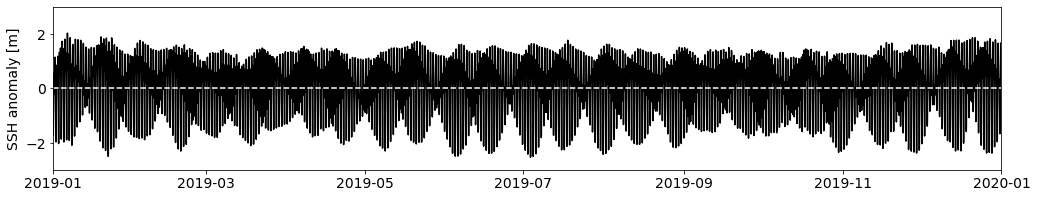

In [61]:
# Plot timeseries
fig, ax = plt.subplots(figsize=(17, 3))
xlim, ylim = [datetime(2019, 1, 1), datetime(2020, 1, 1)], [-3, 3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('SSH anomaly [m]')
ax.plot(time, ssh, 'k-')
ax.plot(xlim, [0, 0], 'w--')
plt.show()

***

## Spectral analysis

First perform a simple FFT. For this task we use the `scipy.fft` library https://docs.scipy.org/doc/scipy/reference/fft.html

Specifically, we use the following function:

   * `fft.rfft`: performs the discrete Fourier transform as described in https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html

In [65]:
ssh_detrended = ssh - ssh.mean()

# Construct the frequency array (Nyquist frequency for hourly data 12 cpd)
frequency = np.linspace(0, 12, len(ssh)//2+1)

# Perform the discrete fourier transform using rfft
amplitude = abs(fft.rfft(ssh_detrended)) # * signal.blackman(len(ssh))))

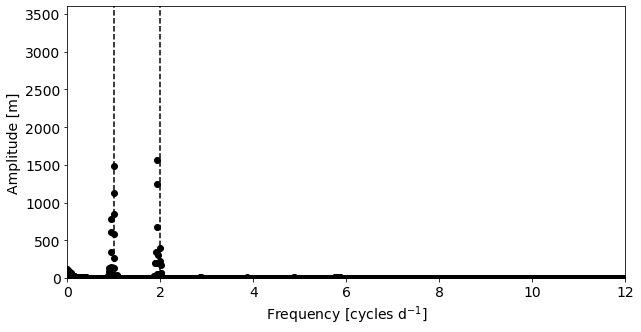

In [63]:
# Make figure
fig, ax = plt.subplots(figsize=(10, 5))
xlim, ylim = [0, 12], [0, 3600]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Frequency [cycles d$^{-1}$]')
ax.set_ylabel('Amplitude [m]')

# Plot the results
ax.plot(frequency, amplitude, 'ko')

# Overlay semidiurnal and diurnal frequencies
for day in [0.5, 1]:
    ax.plot([1/day, 1/day], ylim, 'k--')

plt.show()

We can clearly see the semidiurnal and diurnal amplitude peaks in this spectral plot, but the subtidal signals aren't very distinct. Log axes can improve the detail of the subtidal signals. Also, it can be useful to convert to cycles per day. Notice that in log space the fortnightly and monthly dependence becomes visible.

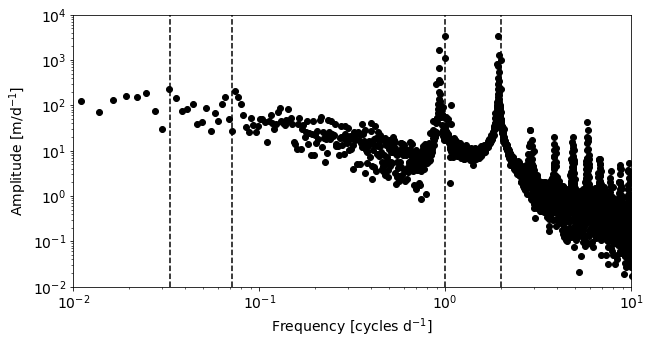

In [66]:
# Make figure
fig, ax = plt.subplots(figsize=(10, 5))
xlim, ylim = [1e-2, 1e1], [1e-2, 1e4]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Frequency [cycles d$^{-1}$]')
ax.set_ylabel('Amplitude [m/d$^{-1}$]')

# Plot the results
ax.plot(frequency, amplitude, 'ko')

# Overlay semidiurnal, diurnal, fortnightly and monthly frequencies
for day in [30, 14, 1, 0.5]:
    ax.plot([1/day, 1/day], ylim, 'k--')

plt.show()